<a href="https://colab.research.google.com/github/sjtao98/NUCL610/blob/main/Project3/Project3_Sn_NUCL610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT 3 - NUCL 610
# Sn Method

## Preparation and Initialization





In [ ]:
import math as m
import cmath as cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import roots_legendre, eval_legendre


In [ ]:
# Global variables to be accessed anywhere
global ng, nregions, geom_length, nmesh_per_region, materials, \
        XS_num, nmesh, geom, xs, BC, \
        s0, s1, s2, curns, phi, adfs, Chi, l, r, ab, tr, nf, scat, even_moments, \
        nx, ny, Dtilda, D_hat, D2tilda, A1, A2, A12, A21, b1, b2, Dc, Keff, iter, iter_max, \
        lamb, lamb_prev, eshift, eshift0, eshift_r, wiel, lamb_s, \
        psi, psid, sf_prev, Am, src,\
        ang_flux

################################################################
#                         Data Input                           #
# ------------------------------------------------------------ #
# ng = number of energy groups                                 #
# nregions = Number of total regions in geometry               #
# materials = List of materials with a length of nmesh         #
# nmesh_per_reg = Number of refined meshes per material region #
# nmesh = Number of total meshes in geometry                   #
# BC = Boundary conditions (0=refl, 1=zero flux, 2=vacuum)     #
################################################################

ng = 2
nregions = 5
geom_length = 100
nmesh_per_region = 16
norder = 8 # For Sn method
materials  = ['MOX']*nregions#['UO2','MOX','UO2','MOX','UO2']
lam_init = 1.2
wiel = True
show_iter = True
log_plot = True
BC = [0,2]
beta_l = 1.0 # left albedo
beta_r = 0.0 # right albedo
data = [[8.873837e-3,	5.424022e-3,	2.332139e-1,	1.592122e-2],
        [6.377025e-2,	9.959442e-2,	8.918111e-1,	0],
        [1.406811e-2, 1.126274e-2,	2.219159e-1,	1.147102e-2],
        [2.691350e-1, 4.577393e-1,	1.043375e+0,	0]]



# Assign enum to XS names
ab   = 0
nf   = 1
tr   = 2
scat = 3
XS_num = 4

# Process input
nmesh = nregions * nmesh_per_region
lmesh = geom_length / nmesh
geom = [lmesh]*nmesh
xs = np.zeros([nmesh, XS_num, ng])
mat_xs = {'UO2':{0:{}, 1:{}, 2:{}, 3:{}}, 'MOX':{0:{}, 1:{}, 2:{}, 3:{}}}

# Initialize matrices
phi     = np.ones([nmesh,ng])
sf      = np.ones([nmesh])
ss      = np.ones([nmesh])
psi     = np.zeros([nmesh])
psid    = np.zeros([nmesh])
sf_prev = np.ones([nmesh])

Dc      = np.ones([nmesh+1,ng])
D_hat   = np.zeros([nmesh+1,ng])
Dtilda  = np.zeros([nmesh+1,ng])
D2tilda = np.zeros([nmesh+1,ng,2]) # left and right

# only 1 in first group of fuel
Chi      = np.ones([nmesh,ng])
Chi[:,1] = .0

# Constants
l = 0 
r = 1
even_moments = True

# Dimensions
nx = nmesh
ny = 1

# Iterations
iter = 0
iter_max = 500

# Wielandt
# fraction of fission source remaining on RHS after eigenvalue shift
eshift_r = 0.1
# eigenvalue error estimation factor
eshift0  = 10
eshift   = eshift_r

# redefine materials
new_materials = []
for mat in materials:
  for idx in range(nmesh_per_region):
    new_materials.append(mat)

# process xs
for idx,mat in enumerate(mat_xs.keys()):
  offset = idx*ng
  for xs_type in range(XS_num):
    for g in range(ng):
      mat_xs[mat][xs_type][g] = float(data[g+offset][xs_type])
      
# process GEOM
for idx,mat in enumerate(new_materials):
  offset = idx*ng
  for xs_type in range(XS_num):
    for g in range(ng):
      xs[idx][xs_type][g] = mat_xs[mat][xs_type][g]

# Sources
lamb = lam_init
lamb_prev = 0.1
Keff = 1/lamb
for idx in range(nmesh):
  for g in range(ng):
    sf[idx] = sf[idx] + phi[idx][g]*xs[idx][nf][g]   # fission source
    ss[idx] = ss[idx] + phi[idx][g]*xs[idx][scat][g] # scattering source
  psi[idx] = sum(xs[idx][nf]) * geom[idx]

# CMFD matrix
A1  = np.zeros([nmesh,nmesh])
A2  = np.zeros([nmesh,nmesh])
A12 = np.zeros([nmesh,nmesh])
A21 = np.zeros([nmesh,nmesh])
b1  = np.zeros([nmesh])
b2  = np.zeros([nmesh])
Am  = np.vstack([np.hstack([A1, A21]), np.hstack([A12, A2])])
src = np.hstack([b1,b2])

# Sn variables
ang_flux = np.ones([nmesh,ng,norder])
surf_ang_flux = np.ones([nmesh+1,ng,norder])
scal_flux = np.ones([nmesh,ng,norder+1])
sn_sf  = np.zeros([nmesh])
sn_ss  = np.zeros([nmesh,ng,norder])
sn_source  = np.zeros([nmesh,ng,norder])




## CMFD

In [ ]:
def UpdateEigen():
  '''
  Updates eigenvalue.
  '''
  global lamb_prev, lamb, sf, psid, psi, Keff, sf_prev, wiel

  lamb_prev = lamb
  if wiel:
    # Multiply eigenvalue shift by <F*flux_n> / <F*flux_n+1>
    gamma_d, gamma_n = 0,0
    for idx in range(nmesh):
      psid[idx] = psi[idx]
      psi[idx]  = sf[idx] * geom[idx]
      gamma_d += psid[idx] * psi[idx]
      gamma_n += psi[idx] * psi[idx]

    # new lambda is original shift + new shift
    lamb = lamb_s + (lamb_prev - lamb_s) * gamma_d/gamma_n

  else:
    # Ordinary way
    lamb = lamb_prev*sum(sf_prev)/sum(sf)
  
  # Determine keff from lambda
  Keff = 1/lamb
  
  return

In [ ]:
def Wiel():
  '''
  Wielandt shift to create new linear system.
  '''
  global eshift, eshift0, eshift_r, lamb, lamb_s, lamb_prev, \
          psi, ss, sf, A1, b1, A2, b2, xs, iter
  
  # Error
  eig_err = abs(lamb - lamb_prev)

  # Calculate shift
  lamb_s = eshift * max(0.3, lamb - eshift0*eig_err)
  lamb_del = lamb - lamb_s

  # Apply shift
  for idx in range(nmesh):
    A1[idx][idx]  -= sum(geom[idx] * xs[idx][nf]) * lamb_s
    fs = psi[idx] * lamb_del
    b1[idx]       = Chi[idx,0] * fs
    b2[idx]       = Chi[idx,1] * fs

  return

In [ ]:
def CMFD():
  '''
  Updates flux between nodal and FDM methods 
  '''
  global geom, phi, lamb, lamb_prev, Dtilda, D_hat, D2tilda, A1, A2, A12, A21, b1, b2, \
          iter, iter_max, nmesh, curns, Keff, wiel, psi, psid, sf, ss, sf_prev, Am, src

  # Initialize error and tolerance
  tol1 = 1E-7
  tol2 = 1E-5
  error1 = np.abs(lamb-lamb_prev)/lamb_prev
  error2 = 0.0
  for idx in range(nmesh):
    sf_change = np.abs(sf[idx] - sf_prev[idx])/sf_prev[idx]
    error2 = max(sf_change,error2)

  # Diffusion Coefficients
  for idx in range(nmesh):  
    Dc[idx] = 1/3*np.reciprocal(xs[idx][tr])

  for idx in range(nmesh+1):
    for g in range(ng):
      if idx==0:
        if BC[0] == 0:
          Dtilda[idx][g] = 0.0
        else:
          Dtilda[idx][g] = 1/(1/0.5 + geom[0]/2/Dc[0][g])
      elif idx==nmesh: 
        if BC[1] == 0:
          Dtilda[idx][g] = 0.0
        else:
          Dtilda[idx][g] = 1/(1/0.5 + geom[nmesh-1]/2/Dc[nmesh-1][g])
      else: 
        Dtilda[idx][g] = 1/(geom[idx-1]/2/Dc[idx-1][g] + geom[idx]/2/Dc[idx][g])
  
  # Start outer iteration
  errors = []
  while (error1>tol1):
    if iter >= iter_max:
      print("WARNING: Iteration finished without convergence")
      break
    
    # Run NEM driver
    # NEM_driver()

    # Run Sn Driver
    Sn_driver()

    # Update D2tilda
    for idx in range(nmesh+1):
      for g in range(ng): 
          D2tilda[idx][g][0] = Dtilda[idx][g] - D_hat[idx][g] # left
          D2tilda[idx][g][1] = Dtilda[idx][g] + D_hat[idx][g] # right
    
    # Sets linear system
    SetLS()

    # Wielandt shift
    if wiel:
      Wiel()

    # Solve linear system
    sol = np.linalg.solve(Am, src)

    phi[:,0] = sol[:nmesh]
    phi[:,1] = sol[nmesh:]


    # Calculate FD currents
    curns_array = np.zeros([nmesh+1,ng])
    for idx in range(nmesh+1):
      for ig in range(ng):
        if idx == 0:
          curns_array[idx,ig] = D2tilda[idx][g][1]*phi[idx,ig]
        elif idx == nmesh:
          curns_array[idx,ig] = D2tilda[idx][g][0]*phi[idx-1,ig]
        else:
          curns_array[idx,ig] = D2tilda[idx][g][0]*phi[idx-1,ig] + D2tilda[idx][g][1]*phi[idx,ig]
    #plt.plot(curns_array[:,0])
    #plt.plot(curns_array[:,1])
    #plt.legend(["curns1","curns2"])
    #plt.show()



    # Update sources
    sf_prev = sf.copy()
    sf,ss = np.zeros([nmesh]),np.zeros([nmesh])
    for idx in range(nmesh):
      for g in range(ng):
        sf[idx] += phi[idx][g] * xs[idx][nf][g]   # fission source
        # ss[idx] += phi[idx][g] * xs[idx][scat][g] # scattering source
    
    # Update eigenvalue
    UpdateEigen()

    # Update error
    error1 = np.abs(lamb-lamb_prev)/lamb_prev
    error2 = 0.0
    for idx in range(nmesh):
      sf_change = np.abs(sf[idx]-sf_prev[idx])/sf_prev[idx]
      error2 = max(sf_change,error2) 
    errors.append(error1)
    
    if show_iter:
      print(f"iter {iter:03d}:  Keff:{Keff:.5f}   lambda_err: {error1:.3e}   fission_err: {error2:.3e}")
    iter += 1

  # Normalize flux
  scale = max(phi[0,:])
  phi[:,0] = phi[:,0]/scale
  phi[:,1] = phi[:,1]/scale

  return errors

In [ ]:
def SetLS():
  '''
  Sets up linear system.
  '''
  global xs, geom, nmesh, A1, A2, A12, A21, D2tilda, sf, ss, lamb, Am, src

  for idx in range(nmesh):
    xst1 = xs[idx][ab][0] + xs[idx][scat][0]
    A1[idx][idx] = geom[idx]*xst1 + D2tilda[idx][0][0] + D2tilda[idx+1][0][1]
    A2[idx][idx] = geom[idx]*xs[idx][ab][1] + D2tilda[idx][1][0] + D2tilda[idx+1][1][1]
    A12[idx][idx] = -geom[idx]*xs[idx][scat][0]
    A21[idx][idx] = 0.0

    # left BC  
    if idx==0: 
      A1[idx][idx+1] = -D2tilda[idx+1][0][0]
      A2[idx][idx+1] = -D2tilda[idx+1][1][0]
    
    # right BC
    elif idx==nmesh-1:
      A1[idx][idx-1] = -D2tilda[idx][0][1]
      A2[idx][idx-1] = -D2tilda[idx][1][1]
    
    # interior
    else:
      A1[idx][idx-1] = -D2tilda[idx][0][1]
      A2[idx][idx-1] = -D2tilda[idx][1][1]
      A1[idx][idx+1] = -D2tilda[idx+1][0][0]
      A2[idx][idx+1] = -D2tilda[idx+1][1][0] 
      
    b1[idx]  = Chi[idx,0] * psi[idx] * lamb
    b2[idx]  = Chi[idx,1] * psi[idx] * lamb

  Am = np.vstack([np.hstack([A1, A21]), np.hstack([A12, A2])])
  src = np.hstack([b1,b2])

  return

## Sn Method



In [ ]:
def Sn_driver():

  # Prepare self-scattering data
  scat_gg = np.zeros([nmesh, ng])
  for idx in range(nmesh):
    for ig in range(ng):
      scat_gg[idx][ig] = xs[idx][tr][ig] - (xs[idx][scat][ig] + xs[idx][ab][ig])


  mu, w = roots_legendre(norder)
  Plm = np.zeros([norder+1, norder])
  for l in range(norder+1):
    Plm[l] = eval_legendre(l,mu)
    if iter==0: plt.plot(Plm[l])
  if iter==0: plt.show()

  # Calculate Scalar Flux (phi_lgi)
  for l in range(norder+1):
    for idx in range(nmesh):
      for ig in range(ng):
        scal_flux[idx][ig][l] = 0.0
        for m in range(norder):
          scal_flux[idx][ig][l] += w[m]*ang_flux[idx][ig][m]*Plm[l][m]
  
  # Calculate Source Terms (S_fi)
  sfdx = 0
  scal_flux[:,:,0] = phi.copy()
  for idx in range(nmesh):
    sn_sf[idx] = 0.0
    for ig in range(ng):
      sn_sf[idx] += xs[idx][nf][ig]*scal_flux[idx][ig][0]
    sfdx += sn_sf[idx] * geom[idx]
  #plt.plot(sn_sf)
  #plt.plot(scal_flux[:,0,0], 'red')
  #plt.plot(scal_flux[:,1,0], 'yellow')
  #plt.legend(["snsf","scal_flux[:,0,0]","scal_flux[:,1,0]"])
  #plt.show()

  for m in range(norder):
    for idx in range(nmesh):
      for ig in range(ng):
        sn_ss[idx][ig][m] = 0.0
        for g in range(ng):
          for l in range(norder+1):
            if ig != g:
              sn_ss[idx][ig][m] += (2*l+1) * 0.5 *scal_flux[idx][g][l]*Plm[l][m]*xs[idx][scat][g]
        sn_source[idx][ig][m] = sn_ss[idx][ig][m] + lamb*Chi[idx][ig]*sn_sf[idx] * 0.5
        #print("sn_ss",idx,ig,m,sn_ss[idx][ig][m])

  # Set Sn Linear System and Solve Surface Angular Flux for Interior
  for m in range(norder//2):
    pm = norder-m-1
    for ig in range(ng):
      #solve for m angle
      surf_ang_flux[nmesh][ig][m] = beta_r*surf_ang_flux[nmesh][ig][pm]
      for idx in range(nmesh-1,-1,-1):
        surf_ang_flux[idx][ig][m] = (geom[idx] * sn_source[idx][ig][m] - \
        (geom[idx]/2 * xs[idx][tr][ig] + mu[m]) * surf_ang_flux[idx+1][ig][m])/ \
        (geom[idx]/2 * xs[idx][tr][ig] - mu[m])
      #solve for pm angle
      surf_ang_flux[0][ig][pm] = beta_l*surf_ang_flux[0][ig][m]
      for idx in range(1,nmesh+1):
        surf_ang_flux[idx][ig][pm] = (geom[idx-1] * sn_source[idx-1][ig][pm] - \
        (geom[idx-1]/2* xs[idx-1][tr][ig] - mu[pm]) * surf_ang_flux[idx-1][ig][pm])/ \
        (geom[idx-1]/2* xs[idx-1][tr][ig] + mu[pm])

      #print("surf_ang_flux g m",ig,m,surf_ang_flux[:,ig,m])
      #print("surf_ang_flux g m",ig,pm,surf_ang_flux[:,ig,pm])
      #plt.plot(surf_ang_flux[:,ig,m])
      #plt.plot(surf_ang_flux[:,ig,pm])
      #plt.legend([str(m)+","+str(ig),str(pm)+","+str(ig)])
      #plt.show()

      # Evaluate interior angular flux
      #for idx in range(nmesh):
      #  ang_flux[idx][ig][m] = 0.5 * (surf_ang_flux[idx][ig][m] + surf_ang_flux[idx+1][ig][m])
      #  ang_flux[idx][ig][pm] = 0.5 * (surf_ang_flux[idx][ig][pm] + surf_ang_flux[idx+1][ig][pm])
      #print("ang_flux g m",ig,m,ang_flux[:,ig,m])
      #print("ang_flux g m",ig,pm,ang_flux[:,ig,pm])

  # Evaluate current and D-hat
  curns_array = np.zeros([nmesh+1,ng])
  for idx in range(nmesh+1):
    for ig in range(ng):
      summ = 0.0
      for m in range(norder):
        summ = summ + w[m]*mu[m]*surf_ang_flux[idx][ig][m]
      curns_Sn = summ
      curns_array[idx,ig] = curns_Sn
      #print(iter,idx,ig,surf_ang_flux[idx][ig])
      if idx==0:
        num = curns_Sn - Dtilda[idx][ig]*(0 - phi[idx][ig])
        denom = 0 + phi[idx][ig]
        D_hat[idx][ig] = num/denom 
      elif idx==nmesh:
        num = curns_Sn - Dtilda[idx][ig]*(phi[idx-1][ig] - 0)
        denom = phi[idx-1][ig] + 0
        D_hat[idx][ig] = num/denom       
      else:
        num = curns_Sn - Dtilda[idx][ig]*(phi[idx-1][ig] - phi[idx][ig])
        denom = phi[idx-1][ig] + phi[idx][ig]
        D_hat[idx][ig] = num/denom
      #print("D_hat idx ig",idx,ig,D_hat[idx][ig])
  #plt.plot(curns_array[:,0])
  #plt.plot(curns_array[:,1])
  #plt.legend(["curns1","curns2"])
  #plt.show()
  #print("ig",0,curns_array[:,0])
  #print("ig",1,curns_array[:,1])
          

  return

In [ ]:
def Sn_standalone():

  global geom, phi, lamb, lamb_prev, \
          iter, iter_max, nmesh, curns, Keff, wiel, psi, psid, sf, ss, sf_prev, Am, src
  print("beta_l: " + str(beta_l) + " beta_r: " + str(beta_r))
  print("initial lamb: " + str(lamb) + "  |   inital keff: " + str(Keff))

  # Initialize error and tolerance
  tol1 = 1E-7
  tol2 = 1E-5
  error1 = np.abs(lamb-lamb_prev)/lamb_prev
  error2 = 0.0
  for idx in range(nmesh):
    sf_change = np.abs(sf[idx] - sf_prev[idx])/sf_prev[idx]
    error2 = max(sf_change,error2)
  
  mu, w = roots_legendre(norder)
  print("Gaussian quadrature Nodes and Weight: ")
  #plt.plot(mu)
  #plt.plot(w)
  #plt.legend(['mu', 'w'])
  #plt.show()

  Plm = np.zeros([norder+1, norder])
  for l in range(norder+1):
    Plm[l] = eval_legendre(l,mu)
    #plt.plot(Plm[l])
  #plt.show()

  # Prepare self-scattering data
  scat_gg = np.zeros([nmesh, ng])
  for idx in range(nmesh):
    for ig in range(ng):
      scat_gg[idx][ig] = xs[idx][tr][ig] - (xs[idx][scat][ig] + xs[idx][ab][ig])

  # Start outer iteration
  errors = []
  while (error1>tol1):
    if iter >= iter_max:
      print("WARNING: Iteration finished without convergence")
      break
    # Calculate Scalar Flux (phi_lgi)
    for l in range(norder+1):
      for idx in range(nmesh):
        for ig in range(ng):
          scal_flux[idx][ig][l] = 0.0
          for m in range(norder):
            scal_flux[idx][ig][l] += w[m]*ang_flux[idx][ig][m]*Plm[l][m]
    
    # Calculate Source Terms (S_fi)
    sfdx = 0
    for idx in range(nmesh):
      sn_sf[idx] = 0.0
      for ig in range(ng):
        sn_sf[idx] += xs[idx][nf][ig]*scal_flux[idx][ig][0]
      sfdx += sn_sf[idx] * geom[idx]

    for m in range(norder):
      for idx in range(nmesh):
        for ig in range(ng):
          sn_ss[idx][ig][m] = 0.0
          for g in range(ng):
            for l in range(norder+1):
              if ig != g:
                sn_ss[idx][ig][m] += (2*l+1) * 0.5 *scal_flux[idx][g][l]*Plm[l][m]*xs[idx][scat][g]
              else:
                sn_ss[idx][ig][m] += (2*l+1) * 0.5 *scal_flux[idx][g][l]*Plm[l][m]*scat_gg[idx][ig]
          sn_source[idx][ig][m] = sn_ss[idx][ig][m] + lamb*Chi[idx][ig]*sn_sf[idx] * 0.5

    # Set Sn Linear System and Solve Surface Angular Flux for Interior
    for m in range(norder//2):
      pm = norder-m-1
      for ig in range(ng):
        #solve for m angle
        surf_ang_flux[nmesh][ig][m] = beta_r*surf_ang_flux[nmesh][ig][pm]
        for idx in range(nmesh-1,-1,-1):
          surf_ang_flux[idx][ig][m] = (geom[idx] * sn_source[idx][ig][m] - \
          (geom[idx]/2 * xs[idx][tr][ig] + mu[m]) * surf_ang_flux[idx+1][ig][m])/ \
          (geom[idx]/2 * xs[idx][tr][ig] - mu[m])
        #solve for pm angle
        surf_ang_flux[0][ig][pm] = beta_l*surf_ang_flux[0][ig][m]
        for idx in range(1,nmesh+1):
          surf_ang_flux[idx][ig][pm] = (geom[idx-1] * sn_source[idx-1][ig][pm] - \
          (geom[idx-1]/2* xs[idx-1][tr][ig] - mu[pm]) * surf_ang_flux[idx-1][ig][pm])/ \
          (geom[idx-1]/2* xs[idx-1][tr][ig] + mu[pm])

        #print("surf_ang_flux g m",ig,m,surf_ang_flux[:,ig,m])
        #print("surf_ang_flux g m",ig,pm,surf_ang_flux[:,ig,pm])
        #plt.plot(surf_ang_flux[:,ig,m])
        #plt.plot(surf_ang_flux[:,ig,pm])
        #plt.legend([str(m)+","+str(ig),str(pm)+","+str(ig)])
        #plt.show()

        # Evaluate interior angular flux
        for idx in range(nmesh):
          ang_flux[idx][ig][m] = 0.5 * (surf_ang_flux[idx][ig][m] + surf_ang_flux[idx+1][ig][m])
          ang_flux[idx][ig][pm] = 0.5 * (surf_ang_flux[idx][ig][pm] + surf_ang_flux[idx+1][ig][pm])
        #print("ang_flux g m",ig,m,ang_flux[:,ig,m])
        #print("ang_flux g m",ig,pm,ang_flux[:,ig,pm])

    # Evaluate scalar flux (zeroth moment)
    Curn_Sn = np.zeros([nmesh+1, ng])
    for idx in range(nmesh):
      for ig in range(ng):
        phi[idx][ig] = 0.0
        for m in range(norder):
          phi[idx][ig] += w[m]*ang_flux[idx][ig][m]

    for idx in range(nmesh+1):
      for ig in range(ng):
       summ = 0.0
       for m in range(norder):
         summ = summ + w[m]*mu[m]*surf_ang_flux[idx][ig][m]
       Curn_Sn[idx][ig] = summ
    print("Curn_Sn, ig",0,Curn_Sn[:,0])
    print("Curn_Sn, ig",1,Curn_Sn[:,1])
    plt.plot(Curn_Sn[:,0])
    plt.plot(Curn_Sn[:,1])
    plt.legend(["CurnSn_1","CurnSn_2"])
    plt.show()

    # Update sources
    sf_prev = sf.copy()
    sfdxo = sfdx
    sfdx = 0
    for idx in range(nmesh):
      sn_sf[idx] = 0
      for g in range(ng):
        sn_sf[idx] += phi[idx][g] * xs[idx][nf][g]   # fission source
      sfdx = sfdx + sn_sf[idx] * geom[idx]
    print("sfdxo " + str(sfdxo) + " |  sfdx " + str(sfdx))
    
    # Update eigenvalue
    #UpdateEigen()
    lamb_prev = lamb
    lamb = lamb_prev * sfdxo / sfdx
    Keff = 1 / lamb

    # Update error
    error1 = np.abs(lamb - lamb_prev)/lamb_prev
    error2 = 0.0
    for idx in range(nmesh):
      sf_change = np.abs(sf[idx]-sf_prev[idx])/sf_prev[idx]
      error2 = max(sf_change,error2) 
    errors.append(error1)
    
    if show_iter:
      print(f"iter {iter:03d}:  lamb: {lamb:.5f}  Keff:{Keff:.5f}   lambda_err: {error1:.3e}   fission_err: {error2:.3e}")
    iter += 1
  
  # Normalize flux
  scale = max(phi[0,:])
  phi[:,0] = phi[:,0]/scale
  phi[:,1] = phi[:,1]/scale   


  return

## Plot and Print Results

In [ ]:
def plot_flux(pphi, nmesh, length, plot_type, phi_a, log=False, C=0):
  '''
  Plots flux distribution.
  '''
  global ng

  if plot_type == 'Analytical':
    num = len(pphi)
    nodes = np.linspace(0, 100, num)
  else:
    nodes = [float((i+1/2)*length) for i in range(nmesh)]

  colors = ('blue', 'red')
  for g in range(ng):
    plt.plot(nodes,(pphi[:,g]),label=f'Group {g+1}', color=colors[g])
  
  #plt.xticks([float(i*length) for i in range(nmesh+1)])
  plt.xlabel("x (cm)")
  plt.ylabel(r'$\phi$')
  if log:
    plt.yscale("linear")
  if plot_type == 'Analytical':
    plt.title(f"{plot_type} flux with C10 = 1 / C20 = {C:.06e}")
  else:
    plt.title(f"{plot_type} flux with {nmesh} meshes of length {length} cm")
  
  plt.legend()

  plt.show()

  return

In [ ]:
def plot_flux_diff(phi, nmesh, nregions, nmesh_pr, phi_a, log_plot):
  '''
  Prints and plots the flux differences between numerical and analytical
  '''
  phi_num_avg = []
  phi_ana_avg = []
  lenA = int((len(phi_a)-1)/nregions)
  lenA_mesh = int((len(phi_a)-1)/nmesh)
  phi1_error = []
  phi2_error = []
  
  # Print errors
  print("Error between numerical and analytical solution per region:")
  for idx in range(nregions):
    val1 = sum(phi[slice(idx*nmesh_pr,(idx+1)*nmesh_pr)])/nmesh_pr
    phi_num_avg.append(val1)

    val2 = sum(phi_a[slice(idx*lenA,(idx+1)*lenA)])/lenA
    phi_ana_avg.append(val2)
    print(f"{idx+1}: {abs(val2 - val1)/val2}")

  # TODO: plot errors
  for imesh in range(nmesh):
    iA = int(np.rint((2*imesh+1)/2*len(phi_a)/nmesh))
    phi_ana = sum(phi_a[slice(imesh*lenA_mesh,(imesh+1)*lenA_mesh)])/lenA_mesh
    phi1_error.append(np.abs(1-phi[imesh][0]/phi_ana[0])*100)
    phi2_error.append(np.abs(1-phi[imesh][1]/phi_ana[1])*100)
  meshes = np.linspace(0.0,100.0,num=nmesh) 
  plt.plot(meshes,phi1_error)
  plt.plot(meshes,phi2_error)
  plt.ylabel("Flux Error(%)")
  plt.xlabel("Length (cm)")
  plt.legend(["Group 1","Group 2"])
  plt.show()
  
  return

# Testing


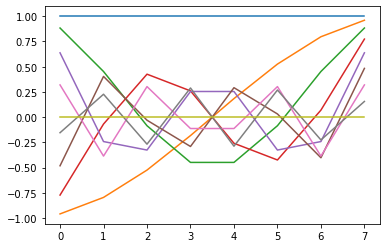

iter 000:  Keff:1.17381   lambda_err: 2.901e-01   fission_err: 8.443e-01
iter 001:  Keff:1.20358   lambda_err: 2.473e-02   fission_err: 1.344e-01
iter 002:  Keff:1.20367   lambda_err: 7.222e-05   fission_err: 8.491e-02
iter 003:  Keff:1.20377   lambda_err: 8.177e-05   fission_err: 6.500e-02
iter 004:  Keff:1.20401   lambda_err: 2.051e-04   fission_err: 5.807e-02
iter 005:  Keff:1.20428   lambda_err: 2.208e-04   fission_err: 5.326e-02
iter 006:  Keff:1.20453   lambda_err: 2.076e-04   fission_err: 4.923e-02
iter 007:  Keff:1.20476   lambda_err: 1.894e-04   fission_err: 4.570e-02
iter 008:  Keff:1.20496   lambda_err: 1.713e-04   fission_err: 4.258e-02
iter 009:  Keff:1.20515   lambda_err: 1.543e-04   fission_err: 3.980e-02
iter 010:  Keff:1.20532   lambda_err: 1.389e-04   fission_err: 3.729e-02
iter 011:  Keff:1.20547   lambda_err: 1.249e-04   fission_err: 3.502e-02
iter 012:  Keff:1.20560   lambda_err: 1.124e-04   fission_err: 3.294e-02
iter 013:  Keff:1.20573   lambda_err: 1.013e-04   f

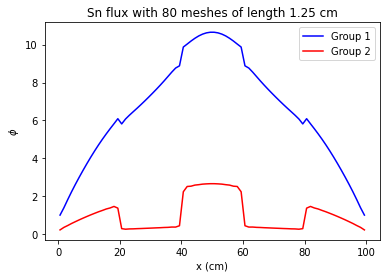


CMFD k-eff for UO2: 1.20700435


In [ ]:
# Run the finite difference calculation
CMFD() 
#Sn_standalone()


# Plot flux
#plot_flux(phi1, nmesh, geom[0], 'CMFD', log_plot)
plot_flux(phi, nmesh, geom[0], 'Sn', log_plot)


# Plot Flux differences
# plot_flux_diff(phi1, nmesh, nregions, nmesh_per_region, phi2, log_plot)

# K-eff error
print(f"\nCMFD k-eff for {materials[0]}: {Keff:.08f}")
#print(f"Analytical  k-eff for {materials[0]}: {keff_a:.08f} " \
#      f"(C10 = {C10}, C20 = {C20})")
#print(f"Error (pcm): {1e5*(Keff-keff_a)/keff_a:.06f}")
